In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import os
import numpy as np
import pandas as pd
import pydicom
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import MultiLabelBinarizer
import os
import numpy as np
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

In [2]:
# params we will probably want to do some hyperparameter optimization later
BASE_MODEL= 'VGG16' 
IMG_SIZE = (224, 224) # [(224, 224), (384, 384), (512, 512), (640, 640)]
BATCH_SIZE = 32 # [1, 8, 16, 24]
DENSE_COUNT = 128 # [32, 64, 128, 256]
DROPOUT = 0.25 # [0, 0.25, 0.5]
LEARN_RATE = 1e-4 # [1e-4, 1e-3, 4e-3]
TRAIN_SAMPLES = 8000 # [3000, 6000, 15000]
TEST_SAMPLES = 800
USE_ATTN = False # [True, False]

In [3]:
image_bbox_df = pd.read_csv('C:/data/stage_2_detailed_class_info.csv')
# image_bbox_df['path'] = image_bbox_df['path'].map(lambda x: 
#                                                   x.replace('input', 
#                                                             'input/rsna-pneumonia-detection-challenge'))
# print(image_bbox_df.shape[0], 'images')
# image_bbox_df.sample(3)

In [4]:
image_bbox_df['class'].value_counts()

class
No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: count, dtype: int64

In [5]:
image_bbox_df['patientId'].unique().shape[0]

26684

In [6]:

image_bbox_df = image_bbox_df.drop_duplicates(subset='patientId')

In [7]:

image_bbox_df['filename'] = image_bbox_df['patientId'] + '.dcm'


train_images = set(os.listdir('C:/data/stage_2_train_images/'))
test_images = set(os.listdir('C:/data/stage_2_test_images/'))



train_df = image_bbox_df[image_bbox_df['filename'].apply(lambda x: x in train_images)].copy()



train_df['path'] = 'C:/data/stage_2_train_images/' + train_df['filename']

print(train_df.shape, 'training data (before splitting)')



(26684, 4) training data (before splitting)


In [8]:
train_df['class'] = train_df['class'].astype(str)  

class_enc = LabelEncoder()
train_df['class_idx'] = class_enc.fit_transform(train_df['class'])


print("Class Mapping:", dict(zip(class_enc.classes_, class_enc.transform(class_enc.classes_))))

Class Mapping: {'Lung Opacity': 0, 'No Lung Opacity / Not Normal': 1, 'Normal': 2}


(21347, 5) training data
(5337, 5) validation data


<Axes: title={'center': 'Validation Set Distribution'}, xlabel='class'>

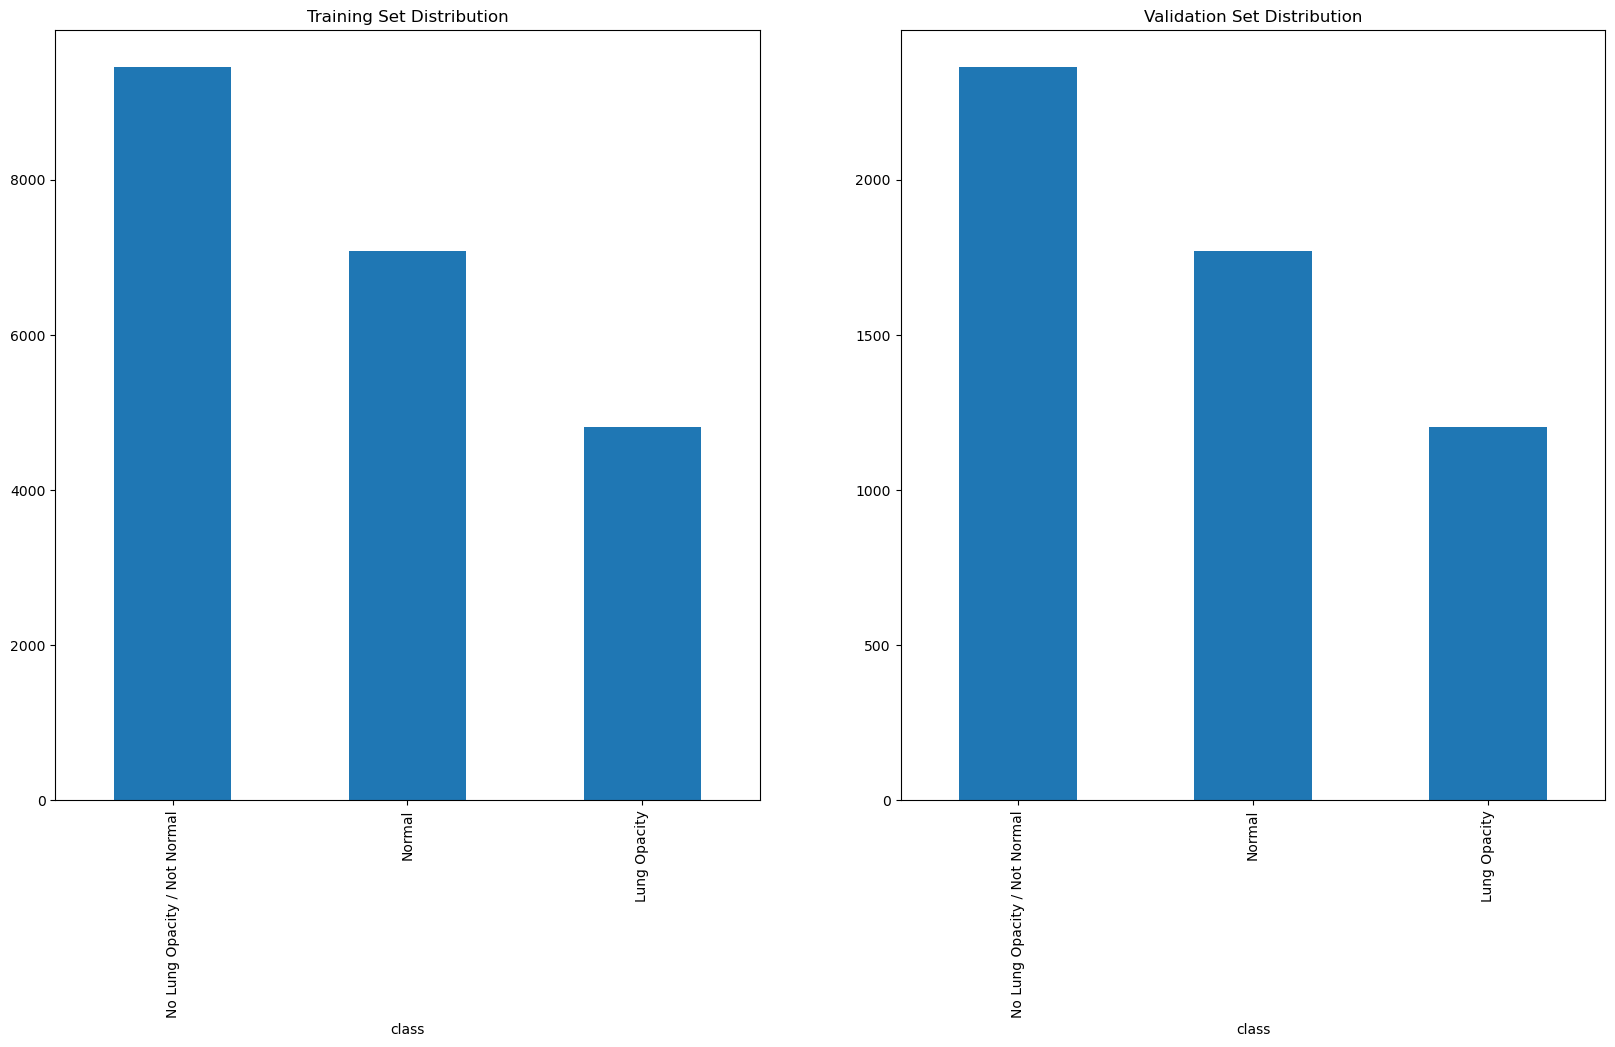

In [9]:

train_df, valid_df = train_test_split(
    train_df, test_size=0.2, random_state=2018, stratify=train_df['class']
)

print(train_df.shape, 'training data')
print(valid_df.shape, 'validation data')


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

train_df['class'].value_counts().plot.bar(ax=ax1, title="Training Set Distribution")
valid_df['class'].value_counts().plot.bar(ax=ax2, title="Validation Set Distribution")

In [10]:

train_df['class_idx'] = train_df['class_idx'].astype(str)
valid_df['class_idx'] = valid_df['class_idx'].astype(str)


## Keras Image Transplantation
Since Keras is design for color jpeg images we need to hack a bit to make it dicom friendly

In [11]:
try:
    # keras 2.2
    import keras_preprocessing.image as KPImage
except:
    # keras 2.1
    import keras.preprocessing.image as KPImage
    
from PIL import Image
import pydicom
def read_dicom_image(in_path):
    img_arr = pydicom.read_file(in_path).pixel_array
    return img_arr/img_arr.max()
    
class medical_pil():
    @staticmethod
    def open(in_path):
        if '.dcm' in in_path:
            c_slice = read_dicom_image(in_path)
            int_slice =  (255*c_slice).clip(0, 255).astype(np.uint8) # 8bit images are more friendly
            return Image.fromarray(int_slice)
        else:
            return Image.open(in_path)
    fromarray = Image.fromarray
KPImage.pil_image = medical_pil

In [12]:
import cv2
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
import pydicom
class DicomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=32, img_size=(224,224), shuffle=True):
        self.df = df
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.df))
        self.on_epoch_end()
        self.index = 0 
    
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        batch_df = self.df.iloc[indexes]
        return self.__data_generation(batch_df)

    def __data_generation(self, batch_df):
        X = np.zeros((self.batch_size, *self.img_size, 3), dtype=np.float32)
        y = np.array(batch_df["class_idx"].values, dtype=np.float32)

        for i, path in enumerate(batch_df["path"]):
            ds = pydicom.dcmread(path)
            img = ds.pixel_array
            img = cv2.resize(img, self.img_size)
            img = np.stack((img,)*3, axis=-1)  
            X[i,] = img  
        X = preprocess_input(X)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __iter__(self):  
        self.index = 0
        return self

    def __next__(self):  
        if self.index >= self.__len__():
            self.index = 0  
            raise StopIteration
        batch = self.__getitem__(self.index)
        self.index += 1
        return batch


train_gen = DicomDataGenerator(train_df, batch_size=32, img_size=(224,224))
valid_gen = DicomDataGenerator(valid_df, batch_size=32, img_size=(224,224))




In [13]:
len(train_gen), len(valid_gen)

(667, 166)

In [14]:
train_df['path'] = train_df['path'].str.replace(' ', '')

In [15]:
train_df['path'] = train_df['path'].str.strip()


train_df['path'] = train_df['path'].apply(lambda x: os.path.normpath(x))


train_df['path'] = train_df['path'].apply(lambda x: x.replace("\\", "/"))


train_df['exists'] = train_df['path'].apply(lambda x: os.path.exists(x))


# Show a batch
Here we see what the augmentation actually looks like on a few sample images

(32, 224, 224, 3) (32,)


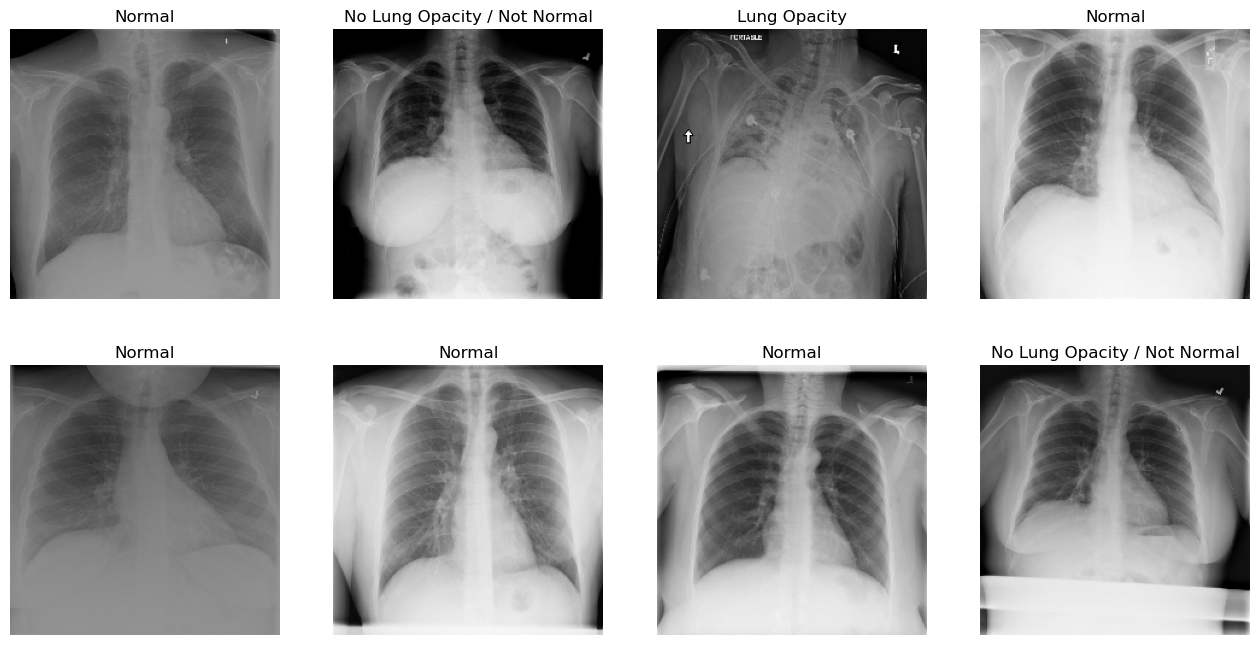

In [17]:
import matplotlib.pyplot as plt
import numpy as np


def deprocess_image(img):
    img = img.copy()
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = np.clip(img, 0, 255).astype(np.uint8)  #
    return img


t_x, t_y = next(train_gen)
print(t_x.shape, t_y.shape)


fig, m_axs = plt.subplots(2, 4, figsize=(16, 8))

for c_x, c_y, c_ax in zip(t_x, t_y, m_axs.flatten()):
    c_x = deprocess_image(c_x)  
    c_ax.imshow(c_x)  
    class_name = class_enc.inverse_transform([int(c_y)])[0]  
    c_ax.set_title(class_name)
    c_ax.axis('off')

plt.show()


# Build our pretrained model
Here we build the pretrained model and download the weights

In [15]:
import os
import numpy as np
import pandas as pd
import pydicom
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

vgg = VGG16(weights=None, include_top=True, input_shape=(224, 224, 3))


base_model = VGG16(weights=None, include_top=True, input_shape=(224, 224, 3))


x = base_model.layers[-2].output 
output = Dense(3, activation="softmax", name="predictions")(x) 

vgg_model = Model(inputs=base_model.input, outputs=output)

vgg_model.summary()




Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [17]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K


def recall_m(y_true, y_pred):
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=3)  
    y_pred = tf.argmax(y_pred, axis=-1) 
    y_pred = tf.one_hot(tf.cast(y_pred, tf.int32), depth=3)

    true_positives = K.sum(y_true * y_pred, axis=0)  
    possible_positives = K.sum(y_true, axis=0)  

    recall = true_positives / (possible_positives + K.epsilon())
    return recall 


def precision_m(y_true, y_pred):
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=3)
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.one_hot(tf.cast(y_pred, tf.int32), depth=3)

    true_positives = K.sum(y_true * y_pred, axis=0)
    predicted_positives = K.sum(y_pred, axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    return precision  


def classwise_f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)

    f1_per_class = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_per_class  


def macro_f1_m(y_true, y_pred):
    f1_per_class = classwise_f1_m(y_true, y_pred)
    return K.mean(f1_per_class) 


def weighted_f1_m(y_true, y_pred):
    f1_per_class = classwise_f1_m(y_true, y_pred)
    

    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=3)
    weights = K.sum(y_true, axis=0)  
    

    weighted_f1 = K.sum(f1_per_class * weights) / (K.sum(weights) + K.epsilon())
    return weighted_f1







In [19]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


vgg_model.compile(optimizer=Adam(learning_rate=1e-4), loss="sparse_categorical_crossentropy", metrics=["accuracy",  macro_f1_m])



In [20]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, 
                                   patience=10, verbose=1, mode='auto', 
                                   epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=10) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [early, reduceLROnPlat]


history = vgg_model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=10,
    callbacks=callbacks_list
)

Epoch 1/10
667/667 [==============================] - 144s 201ms/step - loss: 0.8909 - accuracy: 0.5672 - macro_f1_m: 0.3070 - val_loss: 0.8017 - val_accuracy: 0.6145 - val_macro_f1_m: 0.3136 - lr: 1.0000e-04
Epoch 2/10
667/667 [==============================] - 133s 199ms/step - loss: 0.7862 - accuracy: 0.6254 - macro_f1_m: 0.3194 - val_loss: 0.7641 - val_accuracy: 0.6359 - val_macro_f1_m: 0.3188 - lr: 1.0000e-04
Epoch 3/10
667/667 [==============================] - 135s 202ms/step - loss: 0.7359 - accuracy: 0.6574 - macro_f1_m: 0.3229 - val_loss: 0.7011 - val_accuracy: 0.6666 - val_macro_f1_m: 0.3247 - lr: 1.0000e-04
Epoch 4/10
667/667 [==============================] - 134s 200ms/step - loss: 0.7031 - accuracy: 0.6749 - macro_f1_m: 0.3233 - val_loss: 0.7011 - val_accuracy: 0.6741 - val_macro_f1_m: 0.3239 - lr: 1.0000e-04
Epoch 5/10
667/667 [==============================] - 134s 201ms/step - loss: 0.6765 - accuracy: 0.6886 - macro_f1_m: 0.3240 - val_loss: 0.6778 - val_accuracy: 0.68

In [21]:
vgg_model.save('vggmodel')

INFO:tensorflow:Assets written to: vggmodel\assets


INFO:tensorflow:Assets written to: vggmodel\assets


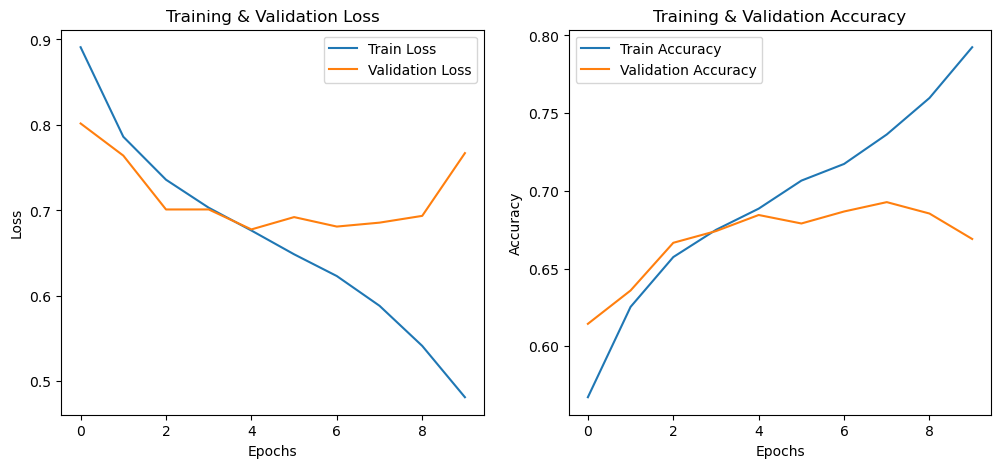

In [22]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()


1/1 [==============================] - 0s 29ms/step


<Figure size 1600x800 with 0 Axes>

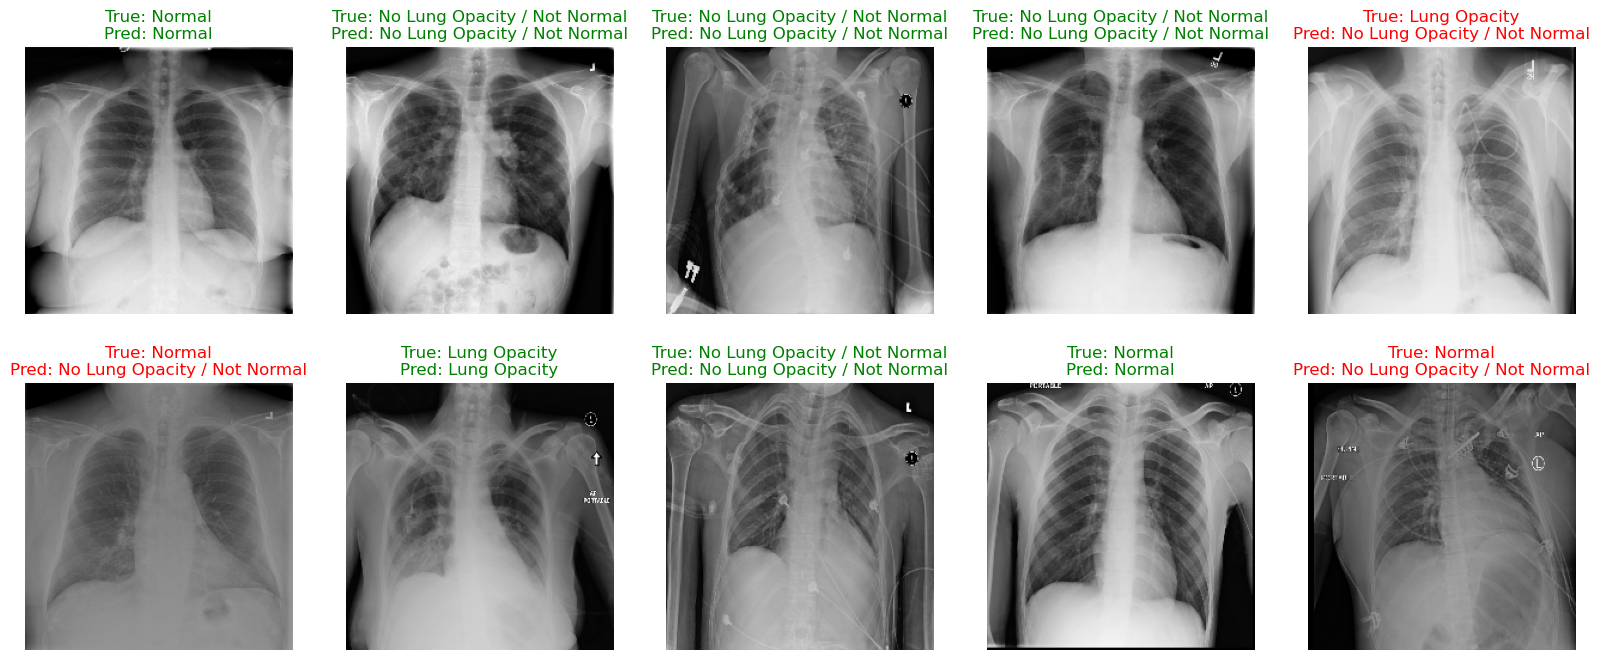

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def vgg_deprocess_image(img):
    img = img.copy()
    img[..., 0] += 103.939  
    img[..., 1] += 116.779  
    img[..., 2] += 123.68  
    img = np.clip(img, 0, 255).astype(np.uint8) 
    return img


x_batch, y_batch = next(valid_gen)


y_pred = vgg_model.predict(x_batch)

y_pred_labels = np.argmax(y_pred, axis=1).astype(int)
y_true_labels = y_batch.astype(int)  


y_pred_classes = class_enc.inverse_transform(y_pred_labels)  
y_true_classes = class_enc.inverse_transform(y_true_labels)


num_images = 8
plt.figure(figsize=(16, 8))

fig, m_axs = plt.subplots(2, 5, figsize=(20, 8))

for i, (c_x, pred_class, true_class, c_ax) in enumerate(zip(x_batch, y_pred_classes, y_true_classes, m_axs.flatten())):
    c_x = vgg_deprocess_image(c_x)  #
    
    c_ax.imshow(c_x)
    c_ax.set_title(f"True: {true_class}\nPred: {pred_class}", fontsize=12, color='green' if true_class == pred_class else 'red')
    c_ax.axis("off")

plt.show()


In [25]:
import os
import pandas as pd


test_dir = "C:/data/stage_2_test_images/"


test_files = [f for f in os.listdir(test_dir) if f.endswith(".dcm")]


test_paths = [os.path.join(test_dir, f) for f in test_files]

sample_test_paths = test_paths[:10]


1/1 [==============================] - 379s 379s/step
File: 0000a175-0e68-4ca4-b1af-167204a7e0bc.dcm, Predicted Class: Normal
File: 0005d3cc-3c3f-40b9-93c3-46231c3eb813.dcm, Predicted Class: No Lung Opacity / Not Normal
File: 000686d7-f4fc-448d-97a0-44fa9c5d3aa6.dcm, Predicted Class: No Lung Opacity / Not Normal
File: 000e3a7d-c0ca-4349-bb26-5af2d8993c3d.dcm, Predicted Class: No Lung Opacity / Not Normal
File: 00100a24-854d-423d-a092-edcf6179e061.dcm, Predicted Class: No Lung Opacity / Not Normal
File: 0015597f-2d69-4bc7-b642-5b5e01534676.dcm, Predicted Class: No Lung Opacity / Not Normal
File: 001b0c51-c7b3-45c1-9c17-fa7594cab96e.dcm, Predicted Class: Normal
File: 0022bb50-bf6c-4185-843e-403a9cc1ea80.dcm, Predicted Class: No Lung Opacity / Not Normal
File: 00271e8e-aea8-4f0a-8a34-3025831f1079.dcm, Predicted Class: Normal
File: 0028450f-5b8e-4695-9416-8340b6f686b0.dcm, Predicted Class: No Lung Opacity / Not Normal


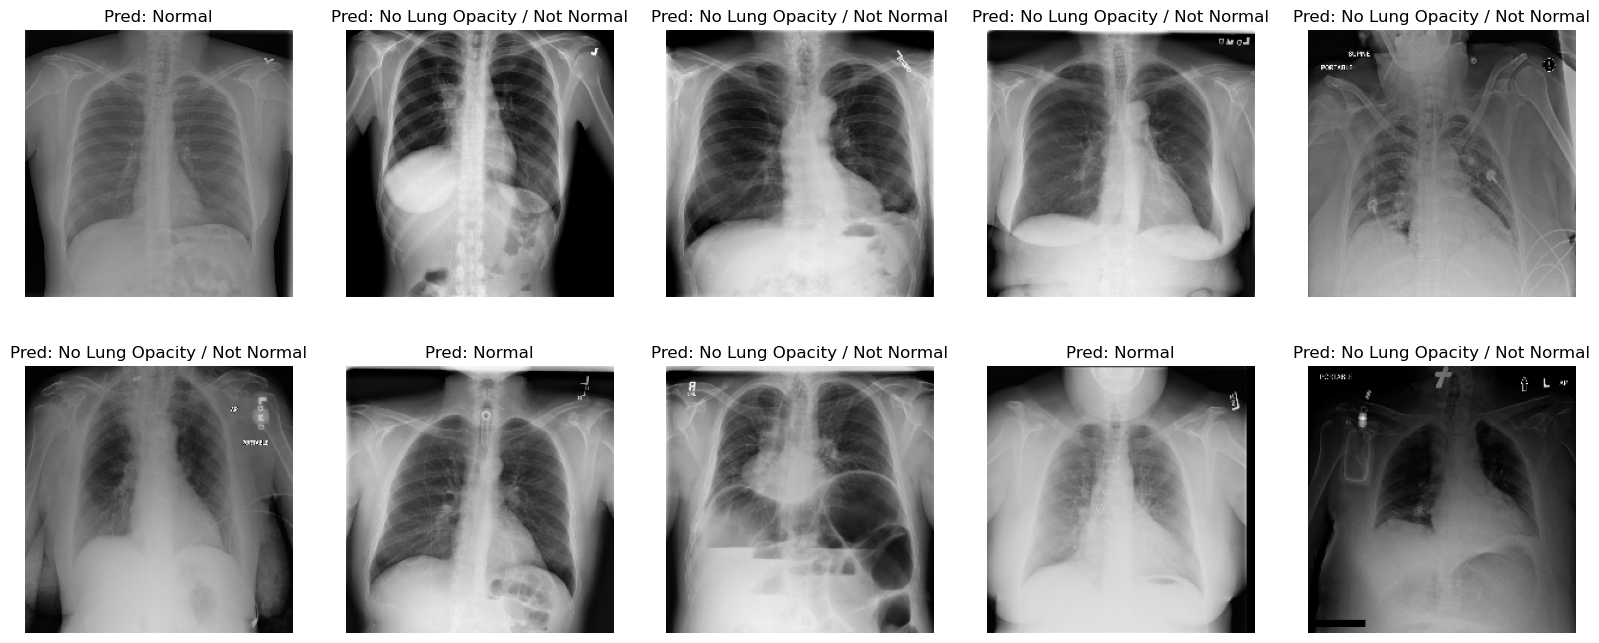

: 

In [ ]:
import numpy as np
import pydicom
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import preprocess_input





def load_dicom_image(path, img_size=(224, 224)):
    ds = pydicom.dcmread(path)  
    img = ds.pixel_array  
    img = cv2.resize(img, img_size)  
    img = np.stack((img,)*3, axis=-1)  
    img = preprocess_input(img.astype(np.float32))  
    return img


test_images = np.array([load_dicom_image(p) for p in sample_test_paths])


predictions = vgg_model.predict(test_images)


predicted_classes = np.argmax(predictions, axis=1)
predicted_class_names = class_enc.inverse_transform(predicted_classes)


for path, pred_class in zip(sample_test_paths, predicted_class_names):
    print(f"File: {os.path.basename(path)}, Predicted Class: {pred_class}")


fig, m_axs = plt.subplots(2, 5, figsize=(20, 8))

for c_x, filename, pred_class, c_ax in zip(test_images, sample_test_paths, predicted_class_names, m_axs.flatten()):
    c_x = c_x + [103.939, 116.779, 123.68]  
    c_x = np.clip(c_x, 0, 255).astype(np.uint8)  
    
    c_ax.imshow(c_x, cmap="bone")
    c_ax.set_title(f"Pred: {pred_class}")
    c_ax.axis("off")

plt.show()
